In [1]:
import os
import sys
from argparse import ArgumentParser
from glob import glob
from loguru import logger
from time import time
from tqdm import tqdm
from yaml import load, FullLoader

import pandas as pd
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from skimage import color
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog, match_descriptors, plot_matches, SIFT
from skimage.transform import resize

from math import floor

In [2]:
sys.path.insert(1,'..')
import functions.fct_misc as misc
from functions.fct_rasters import remove_black_border

logger = misc.format_logger(logger)

## Functions

In [64]:
def im_list_to_hog(im_list, channel_axis=None):
    hog_images = {}
    hog_features = {}
    for name, image in im_list.items():
        ppc = floor(min(image.shape)/6)
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(4, 4), block_norm= 'L2', visualize=True, channel_axis=channel_axis)
        hog_images[name] = hog_image
        hog_features[name] = fd

    return hog_images, hog_features

In [4]:
def print_images(image_dict, v_max):
    f, axarr = plt.subplots(3,3)
    axarr[0,0].imshow(image_dict['0_2570184_1148461.tif'], vmin=0, vmax=v_max)
    axarr[0,1].imshow(image_dict['4_2569842_1149296.tif'], vmin=0, vmax=v_max)
    axarr[0,2].imshow(image_dict['1_2571614_1152259.tif'], vmin=0, vmax=v_max)
    axarr[1,0].imshow(image_dict['5_2569300_1148156.tif'], vmin=0, vmax=v_max)
    axarr[1,1].imshow(image_dict['0_2570190_1148491.tif'], vmin=0, vmax=v_max)
    axarr[1,2].imshow(image_dict['10_2580845_1165703.tif'], vmin=0, vmax=v_max)
    axarr[2,0].imshow(image_dict['4_2569483_1149035.tif'], vmin=0, vmax=v_max)
    axarr[2,1].imshow(image_dict['5_2569281_1148151.tif'], vmin=0, vmax=v_max)
    axarr[2,2].imshow(image_dict['6_2567727_1147671.tif'], vmin=0, vmax=v_max)

## Processing

Argument and parameter specification

In [5]:
with open('../../config/config_symbol_classif.yaml') as fp:
    cfg = load(fp, Loader=FullLoader)['test_notebooks.py']

Load input parameters

In [6]:
WORKING_DIR = cfg['working_dir']
OUTPUT_DIR = cfg['output_dir']
TILE_DIR = cfg['tile_dir']

In [7]:
os.chdir(WORKING_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
logger.info('Read data...')
tile_list = glob(os.path.join(TILE_DIR, '*.tif'))

2024-07-09 10:24:27 - INFO - Read data...


In [9]:
image_data = {}
for tile_path in tile_list:
    with rio.open(tile_path) as src:
        image_data[os.path.basename(tile_path)] = src.read().transpose(1, 2, 0)

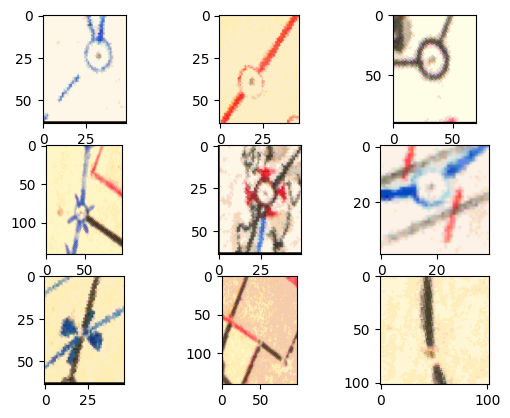

In [10]:
image_dict = image_data
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(image_dict['0_2570184_1148461.tif'])
axarr[0,1].imshow(image_dict['4_2569842_1149296.tif'])
axarr[0,2].imshow(image_dict['1_2571614_1152259.tif'])
axarr[1,0].imshow(image_dict['5_2569300_1148156.tif'])
axarr[1,1].imshow(image_dict['0_2570190_1148491.tif'])
axarr[1,2].imshow(image_dict['10_2580845_1165703.tif'])
axarr[2,0].imshow(image_dict['4_2569483_1149035.tif'])
axarr[2,1].imshow(image_dict['5_2569281_1148151.tif'])
axarr[2,2].imshow(image_dict['6_2567727_1147671.tif'])

In [11]:
data_gray = {key: color.rgb2gray(i) for key, i in image_data.items()}

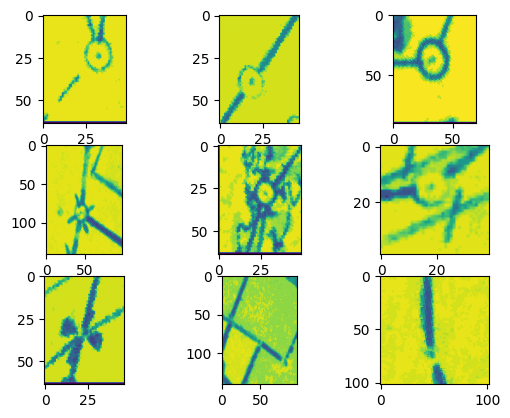

In [12]:
image_dict = data_gray
vmax = 1
print_images(image_dict, vmax)

In [ ]:
data_ratio = {key: np.divide(i[:,:, 2], i[:,:, 0], out=i[:,:, 2].astype(np.float64), where=i[:,:, 0]!=0) for key, i in image_data.items()}

In [ ]:
norm_data_ratio = {key: (i-np.min(i))/(np.max(i)-np.min(i))*255 for key, i in data_ratio.items()}

In [ ]:
image_dict = data_ratio
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(image_dict['0_2570184_1148461.tif'], vmin=0, vmax=image_dict['0_2570184_1148461.tif'].max())
axarr[0,1].imshow(image_dict['4_2569842_1149296.tif'], vmin=0, vmax=image_dict['4_2569842_1149296.tif'].max())
axarr[0,2].imshow(image_dict['1_2571614_1152259.tif'], vmin=0, vmax=image_dict['1_2571614_1152259.tif'].max())
axarr[1,0].imshow(image_dict['5_2569300_1148156.tif'], vmin=0, vmax=image_dict['5_2569300_1148156.tif'].max())
axarr[1,1].imshow(image_dict['0_2570190_1148491.tif'], vmin=0, vmax=image_dict['0_2570190_1148491.tif'].max())
axarr[1,2].imshow(image_dict['10_2580845_1165703.tif'], vmin=0, vmax=image_dict['10_2580845_1165703.tif'].max())
axarr[2,0].imshow(image_dict['4_2569483_1149035.tif'], vmin=0, vmax=image_dict['4_2569483_1149035.tif'].max())
axarr[2,1].imshow(image_dict['5_2569281_1148151.tif'], vmin=0, vmax=image_dict['5_2569281_1148151.tif'].max())
axarr[2,2].imshow(image_dict['6_2567727_1147671.tif'], vmin=0, vmax=image_dict['6_2567727_1147671.tif'].max())

In [ ]:
image_dict = norm_data_ratio
v_max = 255
print_images(image_dict, v_max)

In [ ]:
np.histogram(data_ratio['10_2580845_1165703.tif'], bins=25)

In [ ]:
np.histogram(norm_data_ratio['10_2580845_1165703.tif'], bins=50)

In [ ]:
np.unique(data_ratio['10_2580845_1165703.tif'])[-2]

In [ ]:
image_dict = norm_data_ratio
v_max = 255
print_images(image_dict, v_max)

In [ ]:
# Normalized based on the second highest value
second_norm_data = {key: np.divide((i-np.min(i)), (np.unique(i)[-2]-np.min(i)), out=np.ones_like(i), where=i<=np.unique(i)[-2])*255 for key, i in data_ratio.items()}

In [ ]:
np.histogram(second_norm_data['10_2580845_1165703.tif'], bins=50)

In [ ]:
image_dict = second_norm_data
v_max = 255
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(image_dict['0_2570184_1148461.tif'])
axarr[0,1].imshow(image_dict['4_2569842_1149296.tif'])
axarr[0,2].imshow(image_dict['1_2571614_1152259.tif'])
axarr[1,0].imshow(image_dict['5_2569300_1148156.tif'])
axarr[1,1].imshow(image_dict['0_2570190_1148491.tif'])
axarr[1,2].imshow(image_dict['10_2580845_1165703.tif'])
axarr[2,0].imshow(image_dict['4_2569483_1149035.tif'])
axarr[2,1].imshow(image_dict['5_2569281_1148151.tif'])
axarr[2,2].imshow(image_dict['6_2567727_1147671.tif'])

In [ ]:
# Normalized all value between 0 and 2 to a range of 0 to 255
third_norm_data = {key: np.divide((i-np.min(i)), (2-np.min(i)), out=np.ones_like(i), where=i<2)*255 for key, i in data_ratio.items()}

In [ ]:
np.histogram(third_norm_data['6_2567727_1147671.tif'], bins=50)

In [ ]:
image_dict = third_norm_data
v_max = 255
print_images(image_dict, v_max)

### Hog on scaled data

In [ ]:
hog_scaled_images, hog_scaled_features = im_list_to_hog(third_norm_data)

In [ ]:
np.histogram(hog_scaled_images['6_2567727_1147671.tif'], bins=50)

In [ ]:
image_dict = hog_scaled_images
v_max = 25
print_images(image_dict, v_max)

### HOG on grey images

#### Scale images

In [13]:
cropped_images = {k: remove_black_border(v) for k, v in data_gray.items()}

In [14]:
print(data_gray['13_2584431_1160733.tif'].shape)
print(cropped_images['13_2584431_1160733.tif'].shape)

(75, 48)
(74, 46)


In [15]:
oriented_grey_images = {k: v.transpose(1, 0) if v.shape[1] > v.shape[0] else v for k, v in cropped_images.items()}

Get ratio and size of the images

In [16]:
size_ratio = {k: v.shape[0] / v.shape[1] for k, v in oriented_grey_images.items()}
print(min(size_ratio.values()), max(size_ratio.values()))

1.0 1.9722222222222223


In [31]:
max_size_images = {k: max(v.shape) for k, v in oriented_grey_images.items()}
array_values = np.array(list(max_size_images.values()))
print(min(max_size_images.values()), max(max_size_images.values()), np.median(array_values))

38 140 72.0


In [34]:
min_size_images = {k: min(v.shape) for k, v in oriented_grey_images.items()}
array_values = np.array(list(min_size_images.values()))
print(min(min_size_images.values()), max(min_size_images.values()), np.median(array_values))

36 124 59.0


Text(0.5, 1.0, 'Size Ratio')

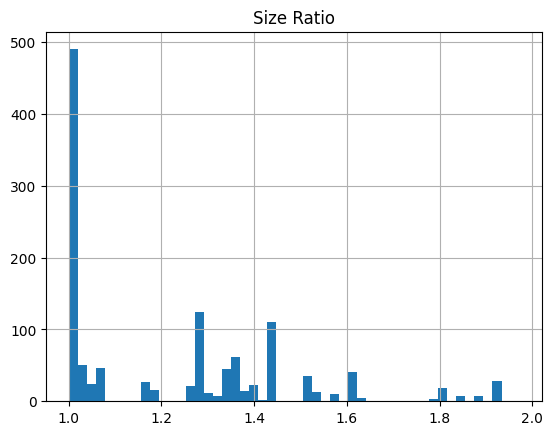

In [17]:
df = pd.DataFrame.from_dict(size_ratio, orient='index')
df.hist(bins=50)
plt.title('Size Ratio')

Text(0.5, 1.0, 'Image size')

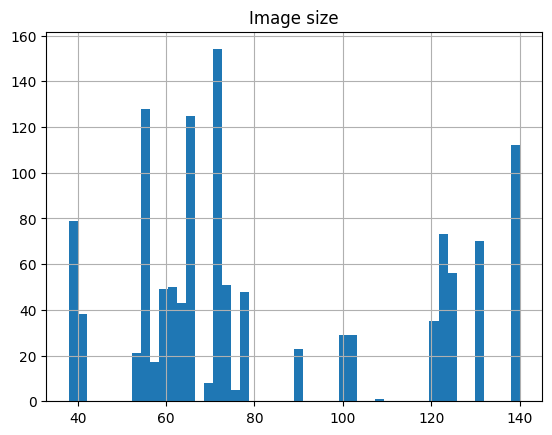

In [27]:
df = pd.DataFrame.from_dict(max_size_images, orient='index')
df.hist(bins=50)
plt.title('Image size')

In [55]:
resized_images = {}
for name, image in cropped_images.items():
    new_size = np.median(array_values)
    if max(cropped_images[name].shape) <= new_size:
        resized_images[name] = resize(cropped_images[name], (new_size, new_size))
    else:
        resized_images[name] = resize(cropped_images[name], (new_size, new_size), anti_aliasing=True)

In [56]:
print(cropped_images['0_2570184_1148461.tif'].shape, cropped_images['4_2569842_1149296.tif'].shape, cropped_images['1_2571614_1152259.tif'].shape)
print(cropped_images['5_2569300_1148156.tif'].shape, cropped_images['0_2570190_1148491.tif'].shape, cropped_images['10_2580845_1165703.tif'].shape)
print(cropped_images['4_2569483_1149035.tif'].shape, cropped_images['5_2569281_1148151.tif'].shape, cropped_images['6_2567727_1147671.tif'].shape)

(62, 49) (63, 47) (90, 70)
(140, 97) (63, 48) (39, 39)
(63, 47) (140, 98) (101, 101)


In [57]:
print(resized_images['0_2570184_1148461.tif'].shape, resized_images['4_2569842_1149296.tif'].shape, resized_images['1_2571614_1152259.tif'].shape)
print(resized_images['5_2569300_1148156.tif'].shape, resized_images['0_2570190_1148491.tif'].shape, resized_images['10_2580845_1165703.tif'].shape)
print(resized_images['4_2569483_1149035.tif'].shape, resized_images['5_2569281_1148151.tif'].shape, resized_images['6_2567727_1147671.tif'].shape)

(72, 72) (72, 72) (72, 72)
(72, 72) (72, 72) (72, 72)
(72, 72) (72, 72) (72, 72)


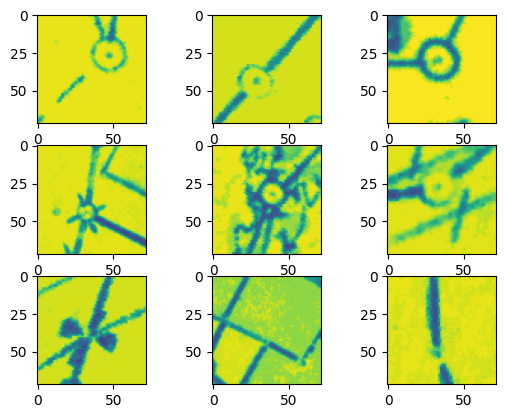

In [58]:
image_dict = resized_images
v_max = 1
print_images(image_dict, v_max)

In [59]:
max_size_images = {k: max(v.shape) for k, v in resized_images.items()}
array_values = np.array(list(max_size_images.values()))
print(min(max_size_images.values()), max(max_size_images.values()), np.median(array_values))

72 72 72.0


#### Apply HOG

In [65]:
hog_gray_images, hog_gray_features = im_list_to_hog(resized_images)

In [66]:
np.histogram(hog_gray_images['6_2567727_1147671.tif'], bins=50)

(array([4280,  472,  112,   94,   34,   30,   10,   10,    2,   14,    8,
           2,    0,    4,   14,    2,    0,   10,    8,    6,    6,    2,
           0,    2,    4,    0,    0,    8,    2,    2,    6,    2,    2,
           0,    0,    0,    0,    0,    2,    8,    4,    0,    6,    0,
           0,    6,    2,    4,    2,    2], dtype=int64),
 array([0.        , 0.00300223, 0.00600447, 0.0090067 , 0.01200894,
        0.01501117, 0.0180134 , 0.02101564, 0.02401787, 0.02702011,
        0.03002234, 0.03302457, 0.03602681, 0.03902904, 0.04203128,
        0.04503351, 0.04803574, 0.05103798, 0.05404021, 0.05704245,
        0.06004468, 0.06304692, 0.06604915, 0.06905138, 0.07205362,
        0.07505585, 0.07805809, 0.08106032, 0.08406255, 0.08706479,
        0.09006702, 0.09306926, 0.09607149, 0.09907372, 0.10207596,
        0.10507819, 0.10808043, 0.11108266, 0.11408489, 0.11708713,
        0.12008936, 0.1230916 , 0.12609383, 0.12909606, 0.1320983 ,
        0.13510053, 0.13810277, 0

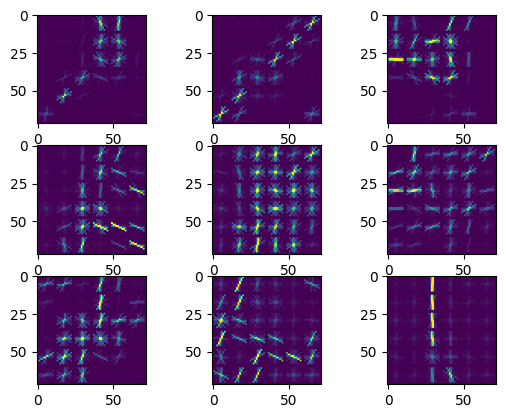

In [68]:
image_dict = hog_gray_images
v_max = 0.1
print_images(image_dict, v_max)

In [69]:
test_list = [len(ft) for ft in hog_gray_features.values()]
(min(test_list), max(test_list))

(1152, 1152)

In [71]:
print(hog_gray_features['0_2570184_1148461.tif'])
print(len(hog_gray_features['0_2570184_1148461.tif']))

[1.03815084e-16 0.00000000e+00 0.00000000e+00 ... 6.67649554e-03
 8.91251879e-03 5.88147746e-03]
1152
